# Assignment 1 - Question 2
### Anya P. Conti

## I. Coding
First we import in all the necessary libraries.  



In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


tf.logging.set_verbosity(tf.logging.INFO)

After that, we load in the data set, and the training and test data and training and test labels to variables. Then we check the shape of the data. Since the labels are not in one-hot formatting, we will need to reformat this.

In [0]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

print("Training set images shape: {shape}".format(shape=data_train.shape))
print("Training set labels shape: {shape}".format(shape=label_train.shape))

print("Test set images shape: {shape}".format(shape=data_test.shape))
print("Test set labels shape: {shape}".format(shape=label_test.shape))

Training set images shape: (50000, 32, 32, 3)
Training set labels shape: (50000, 1)
Test set images shape: (10000, 32, 32, 3)
Test set labels shape: (10000, 1)


After this we set the variables, and one-hot encode the labels.  

In [0]:
batchsize = 128
learningrate = 0.001
epochs = 100
maxbatches = 50
display_step = 10


onehot_encoder = OneHotEncoder(sparse=False)

train_onehot_encoded = onehot_encoder.fit_transform(label_train)
test_onehot_encoded = onehot_encoder.fit_transform(label_test)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

Now we create a function to define the structure of the convolution neural network as specified.  Note: this is without dropout.  

In [0]:
def classification_cnn_nodrop(data, training=False):
    with tf.variable_scope('classification_cnn_nodrop', reuse=tf.AUTO_REUSE):
        # reshape the inputs
        inputs = tf.reshape(data, [-1, 32, 32, 3])

        # convolutional layers
        conv1 = tf.layers.conv2d(inputs=inputs, filters = 32, kernel_size=[5, 5], strides = 1, padding="same", activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        conv2 = tf.layers.conv2d(inputs=pool1, filters = 32, kernel_size=[5, 5], strides = 1, padding="same", activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        conv3 = tf.layers.conv2d(inputs=pool2, filters = 32, kernel_size=[5, 5], strides = 1, padding="same", activation=tf.nn.relu)
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

        # flatten inputs for dense layer
        #flatlay = tf.reshape(pool3, [-1, 12288])  
        flatlay = tf.layers.flatten(pool3)

        # dense layer
        h1 = tf.layers.dense(inputs=flatlay, units=1000, activation=tf.nn.relu)
        
        # output layer
        outputs = tf.layers.dense(inputs=h1, units=10, activation=None)
    return outputs

Now we will use the function above to run the network (with the characteristics mentioned in the problem) 4 times - once with each of the 4 different optimizers: 

- Gradient descent pptimizer
- Adagrad optimizer
- Gradient descent with Nesterov’s momentum
- Adam optimizer

The average loss per epoch from each of these will be stored in a list.  

In [0]:
GradDescLoss_noDrop = []
AdagradLoss_noDrop = []
MomentLoss_noDrop = []
AdamLoss_noDrop = []

for i in range(0,4):
  if i == 0 :
    print("Gradient Descent Optimizer")
  elif i == 1:
    print("Adagrad Optimizer")
  elif i == 2:
    print("Momentum Optimizer")
  else:
    print("Adam Optimizer")

  with tf.variable_scope("main", reuse=tf.AUTO_REUSE):
    X = tf.placeholder(tf.float32, [50000, 32, 32, 3])
    Y = tf.placeholder(tf.float32, [50000, 10])
    Y_labels = tf.argmax(Y, axis = 1)

    dataset = tf.data.Dataset.from_tensor_slices((X, Y_labels)).shuffle(maxbatches*batchsize, reshuffle_each_iteration = False).batch(batchsize)
    iteration = dataset.make_initializable_iterator()
    features, labels = iteration.get_next()

    outputs = classification_cnn_nodrop(features, training = True)


    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=outputs)) 
    
    if i == 0 :
      optimizer = tf.train.GradientDescentOptimizer(learning_rate=learningrate)
    elif i == 1:
      optimizer = tf.train.AdagradOptimizer(learning_rate=learningrate)
    elif i == 2:
      optimizer = tf.train.MomentumOptimizer(learning_rate=learningrate, momentum = 0.001, use_nesterov = True)
    else:
      optimizer = tf.train.AdamOptimizer(learning_rate=learningrate)

    train_op = optimizer.minimize(loss)


  with tf.Session() as sess:

    

    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())


    for epoch in range(epochs):
      totalloss = 0
      sess.run(iteration.initializer, feed_dict = {X : data_train, Y: train_onehot_encoded})
      for j in range(maxbatches):
        _, c = sess.run([train_op, loss])
        totalloss += c 
      avgloss = totalloss / maxbatches
      if i == 0 :
        GradDescLoss_noDrop.append(avgloss)
      elif i == 1:
        AdagradLoss_noDrop.append(avgloss)
      elif i == 2:
        MomentLoss_noDrop.append(avgloss)
      else:
        AdamLoss_noDrop.append(avgloss)
      if (epoch+1) % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avgloss))
    print("Optimization finished!")
  tf.reset_default_graph()


Gradient Descent Optimizer
Epoch: 0010 cost=1.807164783
Epoch: 0020 cost=1.622720809
Epoch: 0030 cost=1.515676851
Epoch: 0040 cost=1.447615266
Epoch: 0050 cost=1.375075421
Epoch: 0060 cost=1.294110186
Epoch: 0070 cost=1.229322191
Epoch: 0080 cost=1.193118886
Epoch: 0090 cost=1.159859421
Epoch: 0100 cost=1.082697574
Optimization finished!
Adagrad Optimizer
Epoch: 0010 cost=1.603322866
Epoch: 0020 cost=1.431905143
Epoch: 0030 cost=1.337717829
Epoch: 0040 cost=1.238168461
Epoch: 0050 cost=1.172058145
Epoch: 0060 cost=1.125663368
Epoch: 0070 cost=1.053298204
Epoch: 0080 cost=1.013709205
Epoch: 0090 cost=0.977845191
Epoch: 0100 cost=0.937195747
Optimization finished!
Momentum Optimizer
Epoch: 0010 cost=2.257435870
Epoch: 0020 cost=2.216849246
Epoch: 0030 cost=2.170164785
Epoch: 0040 cost=2.143007207
Epoch: 0050 cost=2.116087523
Epoch: 0060 cost=2.077899904
Epoch: 0070 cost=1.986120851
Epoch: 0080 cost=1.827540379
Epoch: 0090 cost=1.689234133
Epoch: 0100 cost=1.592254674
Optimization finishe

Now we create a function that defines the structure of the network.  This is essentially the same network as above, but this time with dropout after each pooling layer.  



In [0]:
def classification_cnn_withdrop(data, training=False):
    with tf.variable_scope('classification_cnn', reuse=tf.AUTO_REUSE):
        # reshape the inputs
        inputs = tf.reshape(data, [-1, 32, 32, 3])

        # convolutional layers
        conv1 = tf.layers.conv2d(inputs=inputs, filters = 32, kernel_size=[5, 5], strides = 1, padding="same", activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        drop1 = tf.layers.dropout(inputs=pool1, rate=0.3, training = training)

        conv2 = tf.layers.conv2d(inputs=drop1, filters = 32, kernel_size=[5, 5], strides = 1, padding="same", activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        drop2 = tf.layers.dropout(inputs=pool2, rate=0.3, training = training)

        conv3 = tf.layers.conv2d(inputs=drop2, filters = 32, kernel_size=[5, 5], strides = 1, padding="same", activation=tf.nn.relu)
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
        drop3 = tf.layers.dropout(inputs=pool3, rate=0.3, training = training)

        # flatten inputs for dense layer
        flatlay = tf.layers.flatten(drop3)

        # dense layer
        h1 = tf.layers.dense(inputs=flatlay, units=1000, activation=tf.nn.relu)
        
        # output layer
        outputs = tf.layers.dense(inputs=h1, units=10, activation=None)
    return outputs

Once again, thought this time with the new network structure from the new function, we will run the network (with the characteristics mentioned in the problem) 4 times - once with each of the 4 different optimizers: 

- Gradient descent pptimizer
- Adagrad optimizer
- Gradient descent with Nesterov’s momentum
- Adam optimizer

The average loss per epoch from each of these will be stored in a list.  

In [0]:
GradDescLoss_wDrop = []
AdagradLoss_wDrop = []
MomentLoss_wDrop = []
AdamLoss_wDrop = []

for i in range(0,4):
  if i == 0 :
    print("Gradient Descent Optimizer")
  elif i == 1:
    print("Adagrad Optimizer")
  elif i == 2:
    print("Momentum Optimizer")
  else:
    print("Adam Optimizer")

  with tf.variable_scope("main", reuse=tf.AUTO_REUSE):
    X = tf.placeholder(tf.float32, [50000, 32, 32, 3])
    Y = tf.placeholder(tf.float32, [50000, 10])
    Y_labels = tf.argmax(Y, axis = 1)

    dataset = tf.data.Dataset.from_tensor_slices((X, Y_labels)).shuffle(maxbatches*batchsize, reshuffle_each_iteration = False).batch(batchsize)
    iter = dataset.make_initializable_iterator()
    features, labels = iter.get_next()

    outputs = classification_cnn_withdrop(features, training = True)


    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=outputs)) 
    
    if i == 0 :
      optimizer = tf.train.GradientDescentOptimizer(learning_rate=learningrate)
    elif i == 1:
      optimizer = tf.train.AdagradOptimizer(learning_rate=learningrate)
    elif i == 2:
      optimizer = tf.train.MomentumOptimizer(learning_rate=learningrate, momentum = 0.001, use_nesterov = True)
    else:
      optimizer = tf.train.AdamOptimizer(learning_rate=learningrate)

    train_op = optimizer.minimize(loss)


  with tf.Session() as sess:

    

    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())




    for epoch in range(epochs):
      totalloss = 0
      sess.run(iter.initializer, feed_dict = {X : data_train, Y: train_onehot_encoded})
      for j in range(maxbatches):
        _, c = sess.run([train_op, loss])
        totalloss += c 
      avgloss = totalloss / maxbatches
      if i == 0 :
        GradDescLoss_wDrop.append(avgloss)
      elif i == 1:
        AdagradLoss_wDrop.append(avgloss)
      elif i == 2:
        MomentLoss_wDrop.append(avgloss)
      else:
        AdamLoss_wDrop.append(avgloss)
      if (epoch + 1) % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avgloss))
    print("Optimization finished!")
  tf.reset_default_graph()


Gradient Descent Optimizer
Epoch: 0010 cost=2.226543617
Epoch: 0020 cost=2.133996396
Epoch: 0030 cost=2.067098887
Epoch: 0040 cost=2.023542840
Epoch: 0050 cost=1.956788065
Epoch: 0060 cost=1.937332816
Epoch: 0070 cost=1.876487088
Epoch: 0080 cost=1.865944340
Epoch: 0090 cost=1.845718215
Epoch: 0100 cost=1.806692815
Optimization finished!
Adagrad Optimizer
Epoch: 0010 cost=2.330126848
Epoch: 0020 cost=2.244963470
Epoch: 0030 cost=2.184889407
Epoch: 0040 cost=2.126401424
Epoch: 0050 cost=2.084974430
Epoch: 0060 cost=2.059421237
Epoch: 0070 cost=2.020173383
Epoch: 0080 cost=1.949572482
Epoch: 0090 cost=1.942058516
Epoch: 0100 cost=1.910786242
Optimization finished!
Momentum Optimizer
Epoch: 0010 cost=2.279864459
Epoch: 0020 cost=2.222398009
Epoch: 0030 cost=2.170162611
Epoch: 0040 cost=2.148954096
Epoch: 0050 cost=2.079128368
Epoch: 0060 cost=2.014716363
Epoch: 0070 cost=1.967628512
Epoch: 0080 cost=1.936338902
Epoch: 0090 cost=1.913498325
Epoch: 0100 cost=1.896422603
Optimization finishe

## II. Results

Now that we have the average loss per epoch for each of the 4 optimizers both with dropout and without dropout, we will analyze the results.  First we will compare the performance of each optimizer with dropout and without dropout.  Then, we will compare all the optimizers with dropout, and all the optimizers without dropout.  

### A. Dropout vs No Dropout

With the exception of gradient descent with Nesterov's momentum, all the loss functions with no dropout are lower than the corresponding loss functions with dropout, and are decreasing at a faster rate as well.  This is expected since dropout works by "hurting" the accuracy of the model on the test data to prevent over-fitting, though it might actually help the model improve accuracy when looking at test data.  For gradient descent with Nesterov's momentum, the two seem extremly close until around 40 epochs when the model with dropout actually starts to have a lower loss than that without dropout.  However, this is shortlived, and around 70 epochs, they switch with no dropout having a lower loss, and then they continue to diverge.  I am not sure why this might be.  

#### 1. Gradient Descent Algorithm

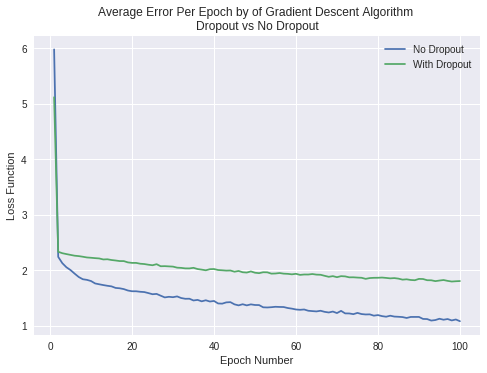

In [0]:
#Graph - Grad Descent
plt.plot(np.arange(1., epochs + 1., 1.), GradDescLoss_noDrop)
plt.plot(np.arange(1., epochs + 1., 1.), GradDescLoss_wDrop)
plt.legend(["No Dropout", "With Dropout"])
plt.title("Average Error Per Epoch by of Gradient Descent Algorithm \nDropout vs No Dropout")
plt.xlabel("Epoch Number")
plt.ylabel("Loss Function")
plt.show()

#### 2. Adagrad Algorithm

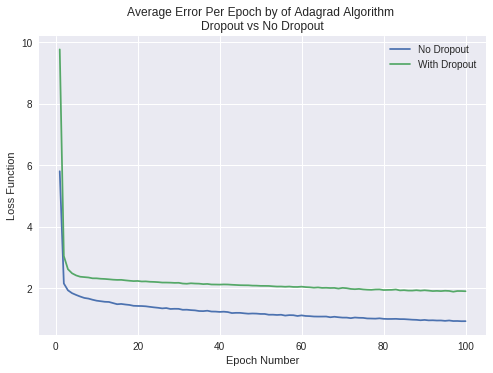

In [0]:
#Graph - Adagrad
plt.plot(np.arange(1., epochs + 1., 1.), AdagradLoss_noDrop)
plt.plot(np.arange(1., epochs + 1., 1.), AdagradLoss_wDrop)
plt.legend(["No Dropout", "With Dropout"])
plt.title("Average Error Per Epoch by of Adagrad Algorithm \nDropout vs No Dropout")
plt.xlabel("Epoch Number")
plt.ylabel("Loss Function")
plt.show()

#### 3. Gradient Descent Algorithm with Nesterov’s momentum

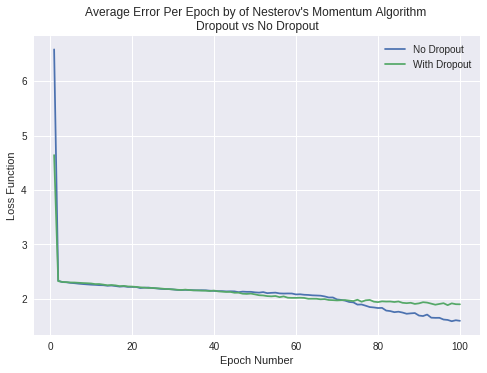

In [0]:
#Graph - Grad Descent with Nesterov's Momentum
plt.plot(np.arange(1., epochs + 1., 1.), MomentLoss_noDrop)
plt.plot(np.arange(1., epochs + 1., 1.), MomentLoss_wDrop)
plt.legend(["No Dropout", "With Dropout"])
plt.title("Average Error Per Epoch by of Nesterov's Momentum Algorithm \nDropout vs No Dropout")
plt.xlabel("Epoch Number")
plt.ylabel("Loss Function")
plt.show()

#### 4. Adam Algorithm

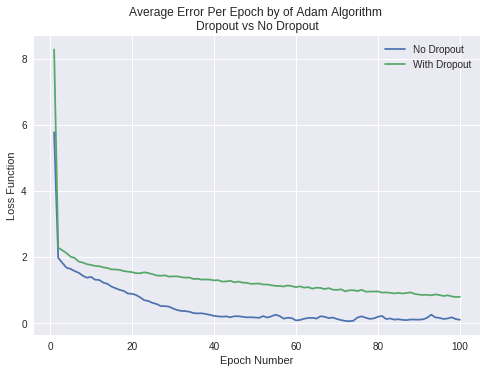

In [0]:
#Graph - Adam
plt.plot(np.arange(1., epochs + 1., 1.), AdamLoss_noDrop)
plt.plot(np.arange(1., epochs + 1., 1.), AdamLoss_wDrop)
plt.legend(["No Dropout", "With Dropout"])
plt.title("Average Error Per Epoch by of Adam Algorithm \nDropout vs No Dropout")
plt.xlabel("Epoch Number")
plt.ylabel("Loss Function")
plt.show()

### B. Comparing the Algorithms Against Each Other

The most obvious thing trend seems to be that Adam has by far the lowest loss function, regardless of whether there is dropout or not.  The others are a little more dependent on whether there is dropout or not.  The loss functions are a lot smoother with dropout, and have more obvious trends.  

#### 1. No Dropout

For the case with no dropout, Adam has the lowest loss function by far, and gradient descent with Nesterov's momentum is by far the highest.  Neither of them have very smooth trends.  Gradient descent and Adagrad have fairly similar trends which are much smoother than the other two. Adagrad is a bit lower than gradient descent.  

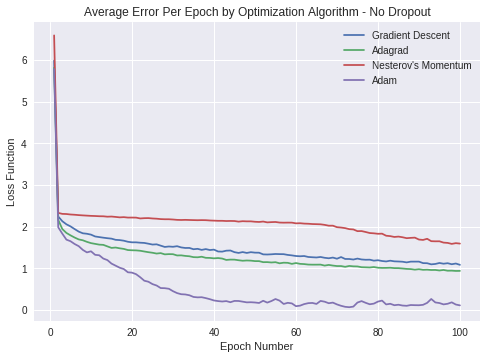

In [0]:
#Graph - no dropout
plt.plot(np.arange(1., epochs + 1., 1.), GradDescLoss_noDrop)
plt.plot(np.arange(1., epochs + 1., 1.), AdagradLoss_noDrop)
plt.plot(np.arange(1., epochs + 1., 1.), MomentLoss_noDrop)
plt.plot(np.arange(1., epochs + 1., 1.), AdamLoss_noDrop)
plt.legend(["Gradient Descent", "Adagrad", "Nesterov's Momentum", "Adam"])
plt.title("Average Error Per Epoch by Optimization Algorithm - No Dropout")
plt.xlabel("Epoch Number")
plt.ylabel("Loss Function")
plt.show()

#### 2. With Dropout

The trends here are in general a lot smoother than compared to with dropout.  Adam has the lowest loss by quite a bit.  The other three are fairly similar, with gradient descent coming next.  The other two are almost indistinguishable, but Adagrad has a slightly higher loss function.  

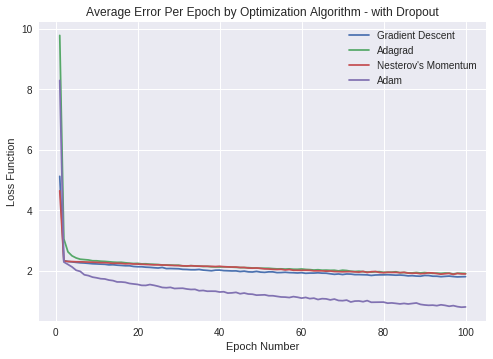

In [0]:
#Graph - with dropout
plt.plot(np.arange(1., epochs + 1., 1.), GradDescLoss_wDrop)
plt.plot(np.arange(1., epochs + 1., 1.), AdagradLoss_wDrop)
plt.plot(np.arange(1., epochs + 1., 1.), MomentLoss_wDrop)
plt.plot(np.arange(1., epochs + 1., 1.), AdamLoss_wDrop)
plt.legend(["Gradient Descent", "Adagrad", "Nesterov's Momentum", "Adam"])
plt.title("Average Error Per Epoch by Optimization Algorithm - with Dropout")
plt.xlabel("Epoch Number")
plt.ylabel("Loss Function")
plt.show()